In [224]:
#As always, we import everything
import pandas as pd
import os
import re
import hdf5_getters as getters
import requests
from bs4 import BeautifulSoup
import numpy as np
from collections import OrderedDict
from tqdm import tqdm
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
from textblob import Word
import pycountry
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from gensim import corpora, models
import matplotlib.pyplot as plt
import json
import pickle
import lyricfetcher
import csv
import urllib
from urllib.request import urlopen, HTTPError

import sklearn
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sandrayang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sandrayang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [53]:
data_dir = './' + 'data'

# README

For the data collection, we have based ourselves on the Million Song Dataset. From this huge data, we are only interested in four attributes:
- The track id
- The artist name
- The year
- The title

In addition to that, we are also interested in the genre of the songs. Luckily, in the Million Song Dataset website, there is already a dataset with the track id and the genre. Thus, we downloaded the corresponding file. We have the genre information for around 191'000 songs. Moreover, we have direct access to the 4 attributes through an additional dataset of around 500'000 songs provided in the Million song website. 

We decide to limit our analysis on this dataset for two reasons. First, manipulating the whole million songs dataset is both time consuming and would require the use of the cluster. Second, after a fast and simple instruction, we discovered that around 150'000 of the genre id are already in the subset we have found.

Next, we use some APIs to scrap and collect the lyrics on several websites. However, we could not scrape all of our dataset so far, as one scraping operation takes more than 1 second. The whole scraping of the full set would take more than 55 hours, so we will have to find a method to perform it. The success rate of the scraping code on the 200 more recent songs of the data set was 129/200, which is fair but can still be raised by doing more string processing, for instance removing the "(live)" or "(album version)" strings. For the oldest songs, the success of the scraping is near 0, as the old songs are not usually found in the lyrics websites. This is not a major problem since as shown in our analysis later, the vast majority of the songs are recent ones.
Alternatively, we can use an additional dataset from the million song website containing bag of words data. We would like to avoid this alternative as it is a simple count of words in the songs and it removes them from the context in the songs.

In our notebook, we have performed a first descriptive analysis of the merged datasets. The big proportion ( 41%) of the songs' genre is rock. Moreover, although the values of the year attribute range from 1920 to 2010, 91% of the tracks are from the 1980 to 2010. We believe this is due to the rapid growth of Rock from its birth in the fifties to achieve more than 50% of the music industry in the 70s to 80s. In our notebook, we have a plot showing this evolution. In our analysis, due to the genre unbalance, we will use a random subset of the rock music ( or the decade) to balance out the classes.

# Data Collection and Descriptive Analysis

Using an additional dataset obtained from the million song website that contains genre information, we created genre_dataset. This dataset contains genre information for 191401 songs. The cell below contains code for putting this data into a proper-formatted dataframe. Another helpful dataset obtained from the website of million song dataset is one that contains year the track was released. In addition to year, it also contains track_id, the name of the artist, and title of the track. This dataset contains 515576 data points. Since we wanted to analyze the progression of feminism through lyrics over time, and we were also interested in how women were portrayed in different genres of music, we decided to take the intersection of these datasets (inner join on track ID), and the resulting data frame contains 152793 data points. We save it to a csv file for accessing in the future. 

In [54]:
# Resulting Dataset
year_artist_name_title_genre = pd.read_csv(os.path.join(data_dir + "/year_artist_name_title_genre.csv")).set_index('track_id')
year_artist_name_title_genre.head()

year      artist_name                title    genre
track_id                                                               
TRSGHLU128F421DF83  1922   alberta hunter         don't pan me    Blues
TRRAHXQ128F42511FF  1922  barrington levy      looking my love   Reggae
TRFAFTK12903CC77B8  1922  barrington levy   warm and sunny day   Reggae
TRTRKSF12903CFEDD7  1924   vernon dalhart  wreck of the old 97  Country
TRQYSYF128F935F350  1925     bessie smith  careless love blues    Blues

In [55]:
year_artist_name_title_genre.isna().sum()

year           0
artist_name    0
title          0
genre          0
dtype: int64

No missing values !

We are interested in seeing how many songs are present in each genre. 

Rock          62344
Electronic    18043
Pop           11058
Jazz          10662
Rap            8156
Metal          8035
RnB            7692
Country        6652
Reggae         5475
Blues          4228
Folk           3484
Punk           2739
Latin          1954
World          1384
New Age         887
Name: genre, dtype: int64


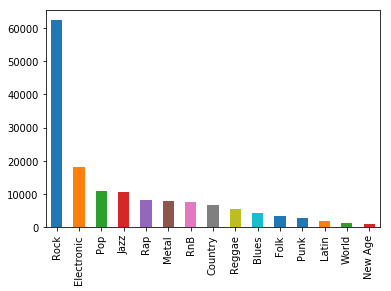

In [56]:
print(year_artist_name_title_genre['genre'].value_counts())

# Visualizing the count using bar graph
value_count_by_genre = year_artist_name_title_genre['genre'].value_counts().plot(kind = 'bar')
value_count_by_genre

In [57]:
# Percentage of rock songs in the dataset

round(100*year_artist_name_title_genre['genre'].value_counts()['Rock']/year_artist_name_title_genre['genre'].value_counts().sum(),3)

40.803

We see an abundance of Rock music in this dataset as close to half of the songs (40.8 %) present are labelled as Rock music. We wonder why that is. Is Rock Music more likely to get labelled? (<- this is a joke). We suspect that this is due to the fast growth of Rock music during the 1990s and 2000s. We will explore the relationship between year and genre of music further to confirm our hypothesis. 

Let us first have a look at the count of music by time. Since it is impossible to visualize the count for every single year, we first group years into decades. Upon quick analysis we realize that the dataset contains music up to the year 2010. We consider 2010 a part of the 2000s. 

In [58]:
# create decade column
year_artist_name_title_genre['decade'] = (year_artist_name_title_genre['year'] // 10) * 10

# include year 2010 in the 2000s decade
year_artist_name_title_genre['decade'] = np.where(year_artist_name_title_genre.year.isin(['2010']),'2000', 
                                                  year_artist_name_title_genre['decade'])

In [59]:
round(100*(year_artist_name_title_genre['decade'].value_counts()['2000'] + \
year_artist_name_title_genre['decade'].value_counts()['1990'] + \
year_artist_name_title_genre['decade'].value_counts()['1980']) / \
year_artist_name_title_genre['decade'].value_counts().sum(),3)

91.361

91% of the tracks are from the eighties to 2010

2000    89699
1990    36693
1980    13201
1970     8340
1960     3580
1950      944
1940      138
1930      111
1920       87
Name: decade, dtype: int64


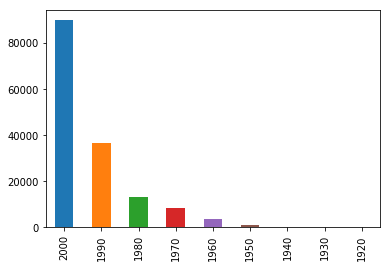

In [60]:
# plot count using bar plot
value_count_by_year = year_artist_name_title_genre['decade'].value_counts().plot(kind = 'bar')

print(year_artist_name_title_genre['decade'].value_counts())
value_count_by_year

We see that there are very few data points earlier than 1970, which makes analysis over time biased. During the next few steps as we explore the relationship between genre and decade further, we only consider the time period of 1970 to 2010. 

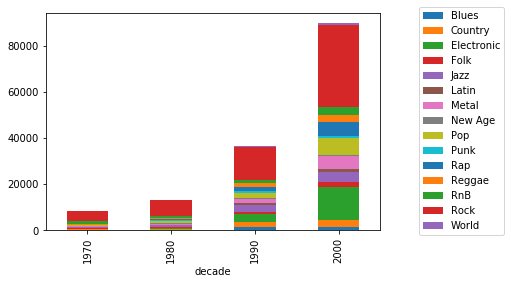

In [61]:
decade_genre = year_artist_name_title_genre[['decade', 'genre']].reset_index()

decade_genre = decade_genre.loc[decade_genre['decade'].isin(['1970','1980','1990','2000'])]

#print(decade_genre.groupby(['decade', 'genre']).size())
plot_decade_genre = decade_genre.groupby(['decade', 'genre']).size().unstack().plot(kind='bar', stacked = True)
plot_decade_genre.legend(bbox_to_anchor=(1.1, 1.05) )


We see that Rock music grew significantly in 40 years. Rock, Electronic, and Pop are the most popular music during the 2000s, followed by metal and Rap. The next plot considers the genres individually, and illustrates their share in the music market over the period of 1970 to 2010. 

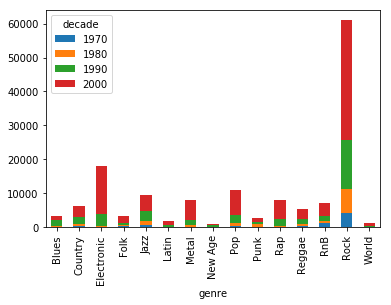

In [62]:
#print(decade_genre.groupby(['genre', 'decade']).size())
decade_genre.groupby(['genre', 'decade']).size().unstack().plot(kind='bar', stacked = True)

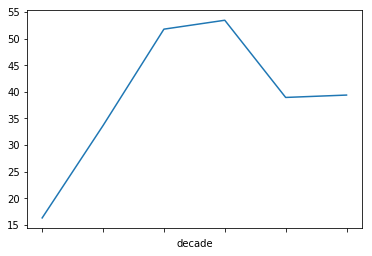

In [63]:
# Evolution of Rock

decade_rock = year_artist_name_title_genre.groupby(['genre','decade']).size()
(100*decade_rock['Rock']/(year_artist_name_title_genre.groupby('decade').size())).plot()


The plot is a bitt hard to read. The curve represents the percentage of rock tracks in our dataset through time. We can clearly see that it has increased drastically from the 60s to 2010. We believe that the slight decrease from 90s is due to the increasing success of RNB, rap, pop and Electronic music during that period.

In [64]:
100*decade_rock['Rock']/(year_artist_name_title_genre.groupby('decade').size())

decade
1920          NaN
1930          NaN
1940          NaN
1950    16.313559
1960    33.659218
1970    51.762590
1980    53.435346
1990    38.936582
2000    39.383940
dtype: float64

# Using the Bag of words model from musicXmatch

In [65]:
# We read the text file line by line 

with open(os.path.join(data_dir, 'mxm_dataset_train.txt')) as f:
    lines = f.readlines()

In [66]:
# The 5'000 most used words sorted by overall occurences are in the 18th line. 
# We split the words by ',' to have a list of words

words = lines[17][1:]
words = words.split(',')

Now, for the rest of the file, we have, for each line, a track id and a list of tuplets. A tuplet ( key:value) consists of:
 - a key ( a number ) which represents the identifier of the word ( 1 means the 1st word in our words list etc ).
 - a value which is the occurences of the word in the track.
 
In the following cells, we extract this information and we change the numbered keys to "word keys"

In [67]:
# First, we split to have a list of tracks

bow = lines[18:]
for i in range(0,len(bow)):
    bow[i] = bow[i].split(',')

For each track in bow and for each tuplet in the track, extract the key ( the numbers before ':') then replace it by the corresponding word

In [68]:
for i in range(0,len(bow)):
    for j in range(2,len(bow[i])):
        '''
        For each track in bow and for each tuplet in the track, extract the key ( the numbers before ':')
        then replace it by the corresponding word
        '''
        key = bow[i][j][ 0 : bow[i][j].find(':') ]
        bow[i][j] = bow[i][j].replace(key,words[int(key)-1])
    # The last tuplet in each track has a line skip special character.
    # The next code will take the last tuplet with the special character
    bow[i][len(bow[i])-1] = bow[i][len(bow[i])-1][0:len(bow[i][len(bow[i])-1])-1]

In [69]:
# Extract the track id 

track_id = []
for i in range(0, len(bow)):
    track_id.append(bow[i][0])

# Lyrics scrapping code

In [70]:
def scrape_lyrics(artists_list,songs_list):
    '''
    Main scrapping function
    Input: lists of songs and their artists names 
    Output: list of lyrics of the songs and list of songs for which the scrapping did not succeed
    In case the scrapping failed, lyrics are returned as empty strings
    
    The lyrics are scrapped from several websites:
    - metrolyrics
    If failed:
    -azlyrics
    If failed also:
    - lyricswikia
    And if it also failed:
    - through the herokuapp online API (unknown source)
    
    '''
    
    lyrics_not_found = []
    if (len(artists_list) == 0 or len(songs_list) == 0):
        raise ValueError('The provided artists list or songs list is empty')
        
    elif (len(artists_list) != len(songs_list)):
        print("artist list has len: ", len(artists_list))
        print("songs list has len: ", len(songs_list))
        raise ValueError('The provided artists and songs lists have different lenghts')
        
    else:
        lyrics = []
        
        for i in tqdm(range(len(artists_list))):
            
            try:
                lyrics_metro = str(lyricfetcher.get_lyrics('metrolyrics',artists_list[i],songs_list[i]))
                lyrics_metro = re.sub(r'[\[].*?[\]]', '', lyrics_metro.replace('\n', ' '))
                lyrics_metro = re.sub(',', '', lyrics_metro)

                if (lyrics_metro == "" or len(lyrics_metro.split())<3):
                    lyrics_az = str(lyricfetcher.get_lyrics('azlyrics',artists_list[i],songs_list[i]))
                    lyrics_az = re.sub(r'[\[].*?[\]]', '', lyrics_az.replace('\n', ' '))
                    lyrics_az = re.sub(',', '', lyrics_az)

                    if (lyrics_az == "" or len(lyrics_az.split())<3):
                        lyrics_wikia = str(lyricfetcher.get_lyrics('lyricswikia',artists_list[i],songs_list[i]))
                        lyrics_wikia = re.sub(r'[\[].*?[\]]', '', lyrics_wikia.replace('\n', ' '))
                        lyrics_wikia = re.sub(',', '', lyrics_wikia)
                        
                        if (lyrics_wikia == "" or len(lyrics_wikia.split())<3):
                            try:
                                lyrics_herokuapp = json.load(urllib.request.urlopen('http://lyric-api.herokuapp.com/api/find/' 
                                                                                + artists_list[i].replace(' ', '%20') + '/' 
                                                                                + songs_list[i].replace(' ', '%20') + '.html'))['lyric']
                            except HTTPError:
                                lyrics_herokuapp = ''
                                
                            lyrics_herokuapp = re.sub(r'[\[].*?[\]]', '', lyrics_herokuapp.replace('\n', ' '))
                            lyrics_herokuapp = re.sub(',', '', lyrics_herokuapp)
                            
                            if (lyrics_herokuapp == "" or len(lyrics_herokuapp.split())<3):
                                lyrics.append("")
                                raise ValueError('No lyrics OR lyrics smaller or equal to 2 words found')
                                
                            else:
                                lyrics.append(lyrics_herokuapp)
                        else:
                            lyrics.append(lyrics_wikia)
                    else:
                        lyrics.append(lyrics_az)

                else:
                    lyrics.append(lyrics_metro)
                    
            except ValueError:
                lyrics_not_found.append([artists_list[i],songs_list[i]])
                continue
    return lyrics, lyrics_not_found

In [71]:
# compute list 'difference' in the sense of objects that are present in one list but not in the other one
def diff(li1, li2): 
    return (list(set(li1) - set(li2))) 

In [72]:
def create_BOW_lyrics_dataframe(artists_to_scrape, titles_to_scrape, dataframe_csv_file_name):

    if any("," in s for s in titles_to_scrape):
        s.replace(",", "")
    
    if any("," in s for s in artists_to_scrape):
        s.replace(",", "")
    
    # The line below calls the scrapping function
    Lyrics, lyrics_not_found_list = scrape_lyrics(artists_to_scrape, titles_to_scrape)

    # Prints relevant information
    print(lyrics_not_found_list)
    print('Count of not found lyrics : ' + str(len(lyrics_not_found_list)))
    
    # Tokenize and stem the lyrics
    from nltk.stem import PorterStemmer
    ps = PorterStemmer()
    
    tokenized_lyrics = []
    
    for lyrics in Lyrics:
        tokens = nltk.word_tokenize(lyrics)
        stemmed_tokens = [ps.stem(token) for token in tokens] 
        tokenized_lyrics.append(stemmed_tokens)

    lyrics_df = pd.DataFrame({'Artists': artists_to_scrape,
                                    'Titles': titles_to_scrape,
                                    'Lyrics(BOW)': tokenized_lyrics
                                   })

    # Save the stemmed version of the lyrics with title and artist to csv

    lyrics_df.to_csv(os.path.join(data_dir + dataframe_csv_file_name)) # Comment/uncomment when saving is needed
    
    return Lyrics, tokenized_lyrics, lyrics_df

## Create positive, feminist playlist dataframe

In [73]:
#Provide BELOW the full set of tracks you would like to get in final (XXX_to_scrape)
#-----------------------------------------------------------------------------
positive_artists_to_scrape = ["Sugababes","Helen Reddy","Gwen Guthrie","Jennifer Lopez","Tinashe","Sheryl Crow","Lisa Stansfield",
                     "Ethel Merman", "Hole", "Geri Halliwell","Hole","Christina Aguilera","Shakira","Cardi B","Destiny's Child",
                    "Meredith Brooks","Lupe Fiasco","Little Mix","Iggy Azalea","Lady Gaga","Fifth Harmony","Kelis","Peaches",
                   "Ariana Grande","Tupac Shakur","Alexandra Burke","La Roux"]
positive_titles_to_scrape = ["About a Girl", "Ain't No Way to Treat a Lady","Ain't Nothin' Goin' On but the Rent","Ain't Your Mama",
                    "All Hands on Deck", "All I Wanna Do", "All Woman","Anything You Can Do (I Can Do Better)",
                    "Asking for It"]

positive_titles_to_scrape += ["Bag It Up",
"Be a Man",
"Beautiful",
"Beautiful Liar",
"Bickenhead",
"Bills Bills Bills",
"Bitch",
"Bitch Bad",
"Black Magic",
"Black Widow",
"Born This Way",
"Boss",
"Bossy",
"Boys Wanna Be Her",
"Break Free",
"Brenda's Got a Baby",
"Broken Heels",
"Bulletproof"]

positive_artists_to_scrape += ["Blondie","Christina Aguilera","Kelly Clarkson","All Saints",
                      "i5","Kelly Rowland", "Remy Ma","Demi Lovato","Janet Jackson","Tori Amos",
                     "TLC",]
positive_titles_to_scrape += ["Call Me", 
"Can't Hold Us Down",
"Catch My Breath",
"Chick Fit",
"Cinderella", 
"Commander",
"Conceited", 
"Confident", 
"Control", 
"Cornflake Girl",
"Creep"]

positive_artists_to_scrape += ["Patti Smith","2Pac","Hole","Beyonce","Janelle Monae","Jessie J","Aretha Franklin",
                     "Mary J. Blige","Chris Janson","Babes in Toyland", "Janelle Monae", "Madonna","Christina Aguilera",
                     "Drake","Janet Jackson","Shane McAnally","Bomshel","Christina Aguilera",
                     "Beyonce","Queenadreena","Kacey Musgraves","Nina Simone"]
positive_titles_to_scrape += ["Dancing Barefoot","Dear Mama","Dicknail","Diva","Django Jane",
                    "Do It like a Dude",
                    "Do Right Woman Do Right Man","Doubt","Drunk Girl","Dust Cake Boy","Electric Lady", 
                    "Express Yourself", "Fall in Line","Fancy","Feedback","Female","Fight Like a Girl",
                     "Fighter","Flawless","FM Doll","Follow Your Arrow","Four Women"]

positive_artists_to_scrape += ["Lady Gaga","Lykke Li","Destiny's Child","Maddie & Tae","Alicia Keys",
                     "Cyndi Lauper","Mary Chapin Carpenter","Ariana Grande","Ashanti","Little Mix",
                     "Robyn","Lily Allen","Mary Chapin Carpenter", "Katy Perry",
                     "David Guetta", "Blu Cantrell", "Gwen Stefani", "Madonna", "Pussycat Dolls",
                     "Jordin Sparks","Kelly Clarkson","Kelly Clarkson","Amil","Christina Aguilera",
                     "Icona Pop", "Gloria Gaynor","Diana Ross","Chaka Khan", "Beyonce","Martina McBride",
                     "Destiny's Child","Beyonce","Whitney Houston","Little Mix","Madonna","No Doubt","2Pac","Christina Aguilera",
                     "TLC","Sonic Youth","Vera Blue","Lush"]
positive_titles_to_scrape += ["G.U.Y.","Get Some","Girl","Girl in a Country Song",
                     "Girl on Fire","Girls Just Want to Have Fun","Girls with Guitars",
                     "God Is a Woman","Good Good","Hair","Handle Me","Hard out Here",
                     "He Thinks He'll Keep Her","Hey Hey Hey","Hey Mama", 
                     "Hit 'Em Up Style (Oops!)","Hollaback Girl","Human Nature","Hush Hush; Hush Hush",
                     "I Am Woman","I Do Not Hook Up",
                     "I Don't Think About You","I Got That","I Hate Boys",
                     "I Love It", "I Will Survive","I'm Coming Out","I'm Every Woman",
                     "If I Were a Boy","Independence Day","Independent Women",
                     "Irreplaceable",
                     "It's Not Right but It's Okay","Joan of Arc","Jump",
                     "Just a Girl","Keep Ya Head Up", "Keeps Gettin' Better", "Kick Your Game","Kool Thing",
                    "Lady Powers","Ladykillers"]

positive_artists_to_scrape += ["Kesha", "Sugarcubes","Idina Menzel","Miley Cyrus","Ciara","Alesha Dixon","Beyonce",
                      "Manic Street Preachers", "Little Mix","Jennifer Lopez","Nicki Minaj","K.Michelle",
                     "Hailee Steinfeld","Zara Larsson","Shania Twain","Cicely Hamilton","Selena Gomez","Beyonce",
                      "Kelly Clarkson","Hailee Steinfeld","Janet Jackson","Dua Lipa","Drake","Meghan Trainor",
                      "Lil B","Barbra Streisand","TLC","Franz Ferdinand","Salt-n-Pepa","Doubleclicks","Mariah Carey",
                      "X-Ray Spex","Tweet","Madonna","Brooke Candy","Katy Perry","Jodi Benson","Beyonce","Nervo",
                      "Taylor Swift","Loretta Lynn","Nirvana","Little Mix","L7","Maggie Lindemann","Keri Hilson",
                      "Britney Spears","Beyonce","Marina and the Diamonds","Janelle Monae"
                     ]
positive_titles_to_scrape += ["Learn to Let Go","Leash Called Love","Let It Go","Liberty Walk","Like a Boy",
                     "Lipstick","Listen","Little Baby Nothing","Little Me","Live It Up","Lookin Ass",
                     "Love 'Em All","Love Myself","Lush Life","Man! I Feel Like a Woman!","The March of the Women",
                     "Me & My Girls","Me Myself and I","Miss Independent","Most Girls",
                    "Nasty","New Rules (song)","Nice for What","No","No Black Person Is Ugly",
                     "No More Tears (Enough Is Enough)","No Scrubs","No You Girls","None of Your Business",
                     "Nothing to Prove","Obsessed", "Oh Bondage Up Yours!","Oops (Oh My)",
                     "Papa Don't Preach","Paper or Plastic","Part of Me","Part of Your World","Partition",
                     "People Grinnin'","Picture to Burn","The Pill","Polly","Power","Pretend We're Dead",
                     "Pretty Girl","Pretty Girl Rock","Pretty Girls","Pretty Hurts","Primadonna","Pynk"]

positive_artists_to_scrape += ["Janelle Monae","Javine","Demi Lovato","Bikini Kill","Sugababes","Aretha Franklin","Katy Perry",
                     "All Saints","Lauryn Hill","Beyonce","Little Mix","Spice Girls","Alessia Cara","The Gits","Mary Lambert",
                     "Green Day","Cyndi Lauper","Camila Cabello","Donna Summer","the Ramones","Lily Allen","Beyonce",
                     "Yoko Ono","Daya","Eliza Doolittle","Demi Lovato","Fifth Harmony","Miley Cyrus","P!nk","Madonna",
                     "Cher","Britney Spears","Kelly Clarkson","P!nk","Alicia Keys","Karyn White","Destiny's Child",
                     "Ava Max","P!nk","Queen Latifah","Fantasia","G.R.L","TLC","Sia","Natasha Bedingfield","Beyonce",
                     "Hole"]

positive_titles_to_scrape += ["Q.U.E.E.N.","Real Things","Really Don't Care","Rebel Girl","Red Dress",
                     "Respect","Roar","Rock Steady","A Rose Is Still a Rose",
                     "Run the World (Girls)","Salute","Say You'll Be There","Scars to Your Beautiful","Second Skin",
                     "Secrets","She","She Bop","She Loves Control","She Works Hard for the Money","Sheena Is a Punk Rocker",
                     "Sheezus","Single Ladies (Put a Ring on It)","Sisters O Sisters","Sit Still Look Pretty",
                    "Skinny Genes","Skyscraper","Sledgehammer","SMS (Bangerz)","So What","Sorry","Strong Enough",
                    "Stronger", "Stronger (What Doesn't Kill You)","Stupid Girls","Superwoman","Superwoman","Survivor", 
                    "Sweet but Psycho","U + Ur Hand","U.N.I.T.Y.","Ugly","Ugly Heart","Unpretty","Unstoppable", 
                     "Unwritten","Upgrade U","Violet"]

positive_artists_to_scrape += ["Spice Girls","Nina Sublatti","Madonna","Gwen Stefani","The Pussycat Dolls","Jody Watley",
                     "The Pussycat Dolls","Vanessa Carlton","Baha Men","Selena Gomez","Robyn","Kelly Clarkson",
                     "Alessia Cara","Gwen Stefani","Kesha","John Lennon","Cher","Britney Spears","Alicia Keys",
                     "Amanda Lear","Fifth Harmony","Yoko Ono","Jax Jones","Lesley Gore","Alanis Morissette"]

positive_titles_to_scrape += ["Wannabe","Warrior","What It Feels Like for a Girl","What You Waiting For?",
                     "Whatcha Think About That","When a Man Loves a Woman","When I Grow Up",
                     "White Houses","Who Let the Dogs Out?","Who Says","Who's That Girl","Whole Lotta Woman",
                     "Wild Things","Wind It Up","Woman","Woman Is the Nigger of the World","Woman's World",
                     "Womanizer","A Woman's Worth","Women", "Worth It","Yang Yang","You Don't Know Me","You Don't Own Me",
                     "You Oughta Know"]
#-----------------------------------------------------------------------------

In [74]:
positive_csv = "/positive_lyrics_dataframe.csv"

In [75]:
lyrics1, positive_tokens, positive_lyrics = create_BOW_lyrics_dataframe(positive_artists_to_scrape, positive_titles_to_scrape, positive_csv)


 74%|███████▍  | 166/224 [07:09<01:13,  1.26s/it]


100%|██████████| 224/224 [08:45<00:00,  2.40s/it]


[['Shane McAnally', 'Female'], ['Mary Chapin Carpenter', 'Girls with Guitars'], ['K.Michelle', "Love 'Em All"], ['Cicely Hamilton', 'The March of the Women'], ['Beyonce', 'Me Myself and I'], ['Doubleclicks', 'Nothing to Prove'], ['Lauryn Hill', 'A Rose Is Still a Rose'], ['G.R.L', 'Ugly Heart'], ['Amanda Lear', 'Women']]
Count of not found lyrics : 9


In [76]:
lyrics1

["Red One Sugababes Girls bring the fun of life sugar like apple pie let's have a party-oh! Let's have a party-oh! Let's have a party-oh! You think I'm sexy huh? I'm international think you can make me fall? What do you know? (What do you know) I'm in my Louis Vuitton's fire like a bomb and I'll be ducking calls 'til I go home ('Til I go home) We like them lights (Yeah we love it) Stars and stripes (L-L-love it) All night (Yeah we love it) I can see You don't know about a girl I'll take over the world and I'm gonna party like woah-oh-oh-oh-oh! You don't know about a girl the meaning of the word 'cos we just wanna party like woah-oh-oh-oh-oh! So we gon' take it oh-oh ha-ay-ah oh-oh ha-ay-oh! oh-oh ha-ay-ah oh-oh ha-ay-oh! So we gon' take it oh-oh ha-ay-ah oh-oh ha-ay-oh! oh-oh ha-ay-ah oh-oh ha-ay-oh! The games you play why can't I play that way I'll break your heart and then I'll mend it up (I'll mend it up) Shine like a disco ball your intuition calls but to me that ball is not enough

### Positive words : results

In [77]:
positive_words = ["woman",'women','pretti','beauti','mama','ladi','better','live','life','worth',
                          'friend','strong','stronger','power','believ','learn','fire','star','best','fight',
                          'free','respect','human','queen','grow','dream','truth','liberti','boss','shine',
                          'sister','flawless','perfect','confid','independ','superwoman']


In [78]:
positive_lyrics = pd.read_csv(os.path.join(data_dir + positive_csv))

positive_lyrics

Unnamed: 0              Artists                                 Titles  \
0             0            Sugababes                           About a Girl   
1             1          Helen Reddy           Ain't No Way to Treat a Lady   
2             2         Gwen Guthrie    Ain't Nothin' Goin' On but the Rent   
3             3       Jennifer Lopez                        Ain't Your Mama   
4             4              Tinashe                      All Hands on Deck   
5             5          Sheryl Crow                         All I Wanna Do   
6             6      Lisa Stansfield                              All Woman   
7             7         Ethel Merman  Anything You Can Do (I Can Do Better)   
8             8                 Hole                          Asking for It   
9             9       Geri Halliwell                              Bag It Up   
10           10                 Hole                               Be a Man   
11           11   Christina Aguilera                              Beautiful   
12           12              Shakira                         Beautiful Liar   
13           13              Cardi B                             Bickenhead   
14           14      Destiny's Child                      Bills Bills Bills   
15           15      Meredith Brooks                                  Bitch   
16           16          Lupe Fiasco                              Bitch Bad   
17           17           Little Mix                            Black Magic   
18           18          Iggy Azalea                            Black Widow   
19           19            Lady Gaga                          Born This Way   
20           20        Fifth Harmony                                   Boss   
21           21                Kelis                                  Bossy   
22           22              Peaches                      Boys Wanna Be Her   
23           23        Ariana Grande                             Break Free   
24           24         Tupac Shakur                    Brenda's Got a Baby   
25           25      Alexandra Burke                           Broken Heels   
26           26              La Roux                            Bulletproof   
27           27              Blondie                                Call Me   
28           28   Christina Aguilera                     Can't Hold Us Down   
29           29       Kelly Clarkson                        Catch My Breath   
..          ...                  ...                                    ...   
194         194                  TLC                               Unpretty   
195         195                  Sia                            Unstoppable   
196         196  Natasha Bedingfield                              Unwritten   
197         197              Beyonce                              Upgrade U   
198         198                 Hole                                 Violet   
199         199          Spice Girls                                Wannabe   
200         200        Nina Sublatti                                Warrior   
201         201              Madonna          What It Feels Like for a Girl   
202         202         Gwen Stefani                  What You Waiting For?   
203         203   The Pussycat Dolls               Whatcha Think About That   
204         204          Jody Watley               When a Man Loves a Woman   
205         205   The Pussycat Dolls                         When I Grow Up   
206         206      Vanessa Carlton                           White Houses   
207         207             Baha Men                  Who Let the Dogs Out?   
208         208         Selena Gomez                               Who Says   
209         209                Robyn                        Who's That Girl   
210         210       Kelly Clarkson                      Whole Lotta Woman   
211         211         Alessia Cara                            Wild Things   
212         212         Gwen Stefani                   

## Same with sexist songs

In [79]:
sexist_artists_to_scrape = ["Foreigner",
                     "Cyndi Lauper",
                     "Ray J",
                     "Adina Howard",
                     "Cassie",
                    "Tone-Loc",
                    "George Michael",
                     "Donna Summer",
                     "Prince", 
                       "Johnny Gill",
                       "Juvenile",
                       "Roberta Flack",
                       "Sylvia",
                       "Def Leppard",
                       "R. Kelly",
                       "Poison",
                       "Marvin Gaye",
                       "Donna Summer",
                       "Labelle",
                       "Peter Gabriel",
                       "Missy Elliott",
                       "The Pointer Sisters",
                       "Heart",
                       "Usher",
                       "Karyn White",
                       "Akon",
                       "R. Kelly",
                       "Bell Biv Devoe",
                       "Silk",
                       "Gregory Abbott",
                       "Starland Vocal Band",
                       "50 Cent" ,
                        "Monica",
                        "Anita Ward",
                        "Nelly Furtado",
                        "Toni Braxton",
                        "Color Me Badd",
                        "Donna Summer",
                        "Lil Wayne",
                        "The Rolling Stones",
                        "Rod Stewart",
                        "Exile",
                        "Madonna",
                        " Captain & Tennille",
                        "Donna Summer",
                        "Marvin Gaye",
                        "Next",
                        "Boyz II Men",
                        "Rod Stewart",
                        "Olivia Newton-John",
                        "Lil Wayne",
                        "The Dead Exs",
                        "Major Lazer",
                        "Young Money",
                        "Enrique Iglesias",
                        "Robin Thicke",
                        "Kiss",
                        "Britney Spears",
                        "Lil Wayne",
                        "Dr. Dre",
                        "David Guetta",
                        "Nicki Minaj",
                        "Whitesnake",
                        "Anal Cunt",
                        "Chris Brown",
                        "Prince",
                        "Falco",
                        "The Mentors",
                        "The Prodigy",
                        "Eminem",
                        "Eminem",
                        "Dierks Bentley",
                        "Nickelback",
                        "Young Money",
                        "Van Halen",
                        "Robert Hazard",
                        "Demi Lovato",
                        "Bon Jovi",
                        "Alannah Myles",
                        "Prince",
                        "Manika",
                        "Christina Aguilera",
                        "Rihanna",
                        "Maroon 5",
                        "Fetty Wap",
                        "Akon",
                        "Raelynn",
                        "Sir Mix A Lot",
                        "Notorious BIG",
                        "Tyler Farr",
                        "Usher",
                        "Syd",
                        "The Citrus Cloud",
                        "Ro James",
                        "SiR",
                        "Miguel",
                        "Charlie Puth",
                        "Miguel",
                        "Nao",
                        "Harry Styles",
                        "Lana Del Rey",
                        "Lana Del Rey",
                        "Shaggy",
                        "The Crystals",
                        "One Direction",
                        "Beatles",
                        "The Weeknd",
                        "Alex Gaudino",
                        "Bob Sinclar",
                        "Vleger",
                        "Sasha Lopez",
                        "David Guetta",
                        "Pitbull",
                        "Eric Prydz",
                        "Madonna",
                        "Fedde Le Grand",
                        "Black Eyed Peas",
                        "Eminem",
                        "Frank Loesser",
                        "Jason Derulo",
                        "YG",
                        "Tyler The Creator",
                        "Dr. Dre",
                        "Outkast",
                        "Eminem",
                        "Waka Flocka Flame",
                        "Lil Wayne",
                        "Ying Yang Twins",
                        "Common",
                        "Ghostface Killah",
                        "Eminem",
                        "Eminem",
                        "Eminem",
                        "Eminem",
                        "Snoop Dog",
                        "Eminem",
                        "Jeremih",
                        "Chris Brown",
                        "Timbaland",
                        "Milow",
                        "Chris Brown",
                        "Akon",
                        "Akon",
                        "Pitbull",
                        "Pitbull",
                        "Rocko",
                        "Rocko",
                        "Asap Rocky",
                        "Benny Benassi"]


sexist_titles_to_scrape = ["Urgent", 
                    "She bop",
                    "Sexy Can I",
                    "Freak Like Me",
                    "Me & U", 
                    "Wild Thing", 
                    "I Want Your Sex",
                    "Dim All The Lights",
                    "Raspberry Beret",
                    "Rub you the Right Way",
                    "Slow Motion",
                    "Feel Like Makin' Love",
                    "Pillow Talk",
                    "Pour Some Sugar on Me",
                    "Bump N' Grind",
                    "Unskinny Bop",
                    "Sexual Healing",
                    "Love To Love You Baby",
                    "Lady Marmalade",
                    "Slegehammer",
                    "Work It",
                    "Slow Hand",
                    "All I Want To Do Is Make Love To You",
                    "Love In This Club",
                    "Romantic",
                    "Smack That",
                    "Ignition",
                    "Do Me!",
                    "Freak Me",
                    "Shake You Down",
                    "Afternoon Delight",
                    "Candy Shop",
                    "The First Night",
                    "Ring My Bell",
                    "Promiscuous",
                    "You're Makin' Me High",
                    "I Wanna Sex You Up",
                    "Bad Girls",
                    "Lollipop",
                    "Honky Tonk Women",
                    "Da Ya Think I'm Sexy",
                    "Kiss You All Over",
                    "Like A Virgin",
                    "Do That To Me One More Time",
                    "Hot Stuff",
                    "Let's Get It On",
                    "Too Close",
                    "I'll Make Love To You",
                    "Tonight's The Night",
                    "Physical",
                    "Love Me",
                    "Shut Up and Love Me",
                    "Bubble Butt",
                    "Lookin' Ass",
                    "Tonight (I'm Fuckin' You)",
                    "Blurred Lines",
                    "I Just Wanna",
                    "I'm a Slave 4 U",
                    "How to Love",
                    "Bitches Ain't Shit",
                    "Hey Mama",
                    "Anaconda",
                    "Slow An' Easy",
                    "Woman: Nature's Punching Bag",
                    "Loyal",
                    "Cream",
                    "Jeanny",
                    "Golden Shower",
                    "Smack My Bitch Up",
                    "Superman",
                    "Love the Way You Lie",
                    "Different for Girls",
                    "Something in Your Mouth",
                    "Every Girl",
                    "Drop Dead Legs",
                    "Girls Just Want to Have Fun",
                    "Body Say",
                    "Let's Make It Baby",
                    "Black Velvet",
                    "Kiss",
                    "I Might Go Lesbian",
                    "Dirrty ",
                    "S&M",
                    "Animals",
                    "679",
                    "I Wanna Fuck You",
                    "God Made Girls",
                    "Baby Got Back",
                    "Nasty Girl",
                    "Redneck Crazy",
                    "Love In This Club",
                    "Smile More",
                    "Lost Wolves",
                    "Burn Slow",
                    "Ooh Nah Nah",
                    "Pussy Is Mine",
                    "Suffer",
                    "...goingtohell",
                    "Bad Blood",
                    "Feels Like",
                    "Love",
                    "Lust For Life",
                    "It Wasn't Me",
                    "He Hit Me",
                    "What Makes You Beautiful",
                    "Run For Your Life",
                    "High For This",
                    "Destination Calabria",
                    "What I Want",
                    "After Night In Ibiza",
                    "Beautiful Life",
                    "Play Hard",
                    "International Love",
                    "Call On Me",
                    "Hung Up",
                    "Put Your Hands Up For Detroit",
                    "My Humps",
                    "Kill You",
                    "Baby It's Cold Outside",
                    "Wiggle",
                    "Toot it and Boot it",
                    "Translyvania",
                    "Bitches Ain't Shit",
                    "Hootie Hoo",
                    "Shake That",
                    "No Hands",
                    "Alphabet Bitches",
                    "Wait Til Ya See My Dick",
                    "Heidi Hoe",
                    "Wildflower",
                    "Ass Like That",
                    "Guilty Conscience",
                    "Cleaning Out My Closet",
                    "The Warning",
                    "Step Yo Game Up",
                    "Without Me",
                    "Birthday Sex",
                    "Wet The Bed",
                    "Carry Out",
                    "Ayo Technology",
                    "Ayo",
                    "Sexy Bitch",
                    "I Just Had Sex",
                    "Hotel Room",
                    "Hey Baby",
                    "You Don't Even Know It",
                    "U.O.E.N.O.",
                    "Fuckin' Problems",
                    "Satisfaction"]

In [80]:
sexist_csv = "/sexist_lyrics_dataframe.csv"

In [81]:
lyrics2, sexist_tokens, sexist_lyrics = create_BOW_lyrics_dataframe(sexist_artists_to_scrape, sexist_titles_to_scrape, sexist_csv)


100%|██████████| 149/149 [03:51<00:00,  1.37s/it]


[['Peter Gabriel', 'Slegehammer'], ['The Dead Exs', 'Shut Up and Love Me'], ['The Citrus Cloud', 'Lost Wolves'], ['SiR', 'Ooh Nah Nah'], ['Harry Styles', 'Feels Like'], ['Vleger', 'After Night In Ibiza'], ['Tyler The Creator', 'Translyvania']]
Count of not found lyrics : 7


In [82]:
sexist_lyrics = pd.read_csv(os.path.join(data_dir + sexist_csv))

sexist_lyrics

Unnamed: 0              Artists                                Titles  \
0             0            Foreigner                                Urgent   
1             1         Cyndi Lauper                               She bop   
2             2                Ray J                            Sexy Can I   
3             3         Adina Howard                         Freak Like Me   
4             4               Cassie                                Me & U   
5             5             Tone-Loc                            Wild Thing   
6             6       George Michael                       I Want Your Sex   
7             7         Donna Summer                    Dim All The Lights   
8             8               Prince                       Raspberry Beret   
9             9          Johnny Gill                 Rub you the Right Way   
10           10             Juvenile                           Slow Motion   
11           11        Roberta Flack                 Feel Like Makin' Love   
12           12               Sylvia                           Pillow Talk   
13           13          Def Leppard                 Pour Some Sugar on Me   
14           14             R. Kelly                         Bump N' Grind   
15           15               Poison                          Unskinny Bop   
16           16          Marvin Gaye                        Sexual Healing   
17           17         Donna Summer                 Love To Love You Baby   
18           18              Labelle                        Lady Marmalade   
19           19        Peter Gabriel                           Slegehammer   
20           20        Missy Elliott                               Work It   
21           21  The Pointer Sisters                             Slow Hand   
22           22                Heart  All I Want To Do Is Make Love To You   
23           23                Usher                     Love In This Club   
24           24          Karyn White                              Romantic   
25           25                 Akon                            Smack That   
26           26             R. Kelly                              Ignition   
27           27       Bell Biv Devoe                                Do Me!   
28           28                 Silk                              Freak Me   
29           29       Gregory Abbott                        Shake You Down   
..          ...                  ...                                   ...   
119         119         Jason Derulo                                Wiggle   
120         120                   YG                   Toot it and Boot it   
121         121    Tyler The Creator                          Translyvania   
122         122              Dr. Dre                    Bitches Ain't Shit   
123         123              Outkast                            Hootie Hoo   
124         124               Eminem                            Shake That   
125         125    Waka Flocka Flame                              No Hands   
126         126            Lil Wayne                      Alphabet Bitches   
127         127      Ying Yang Twins               Wait Til Ya See My Dick   
128         128               Common                             Heidi Hoe   
129         129     Ghostface Killah                            Wildflower   
130         130               Eminem                         Ass Like That   
131         131               Eminem                     Guilty Conscience   
132         132               Eminem                Cleaning Out My Closet   
133         133               Eminem                           The Warning   
134         134            Snoop Dog                       Step Yo Game Up   
135         135               Eminem                            Without Me   
136         136              Jeremih                          Birthday Sex   
137         137          Chris Brown                           Wet The Bed   
138         138            

# Negative words and final feature list

In [83]:
negative_words = ['bitch','bubbl','fuck','nigga','butt','feel','littl','hot','ass',
                   'bodi','shit','hoe','man','sex','shake','bad','hard','dick','touch',
                   'fuckin','pussi','lick','sexi','damn','money']

positive_words = ["woman",'women','pretti','beauti','mama','ladi','better','live','life','worth',
                          'friend','strong','stronger','power','believ','learn','fire','star','best','fight',
                          'free','respect','human','queen','grow','dream','truth','liberti','boss','shine',
                          'sister','flawless','perfect','confid','independ','superwoman']

feature_list = ['Title','BOW']
feature_list = feature_list + positive_words + negative_words

# Finally: neutral ones

In [84]:
neutral_titles_to_scrape =  ["these arms of mine", "she", "green garden", "hotline bling", "three little birds", "masterblaster", "inner city blues", "move on up", "use me", "papa was a rolling stone", "richman poorman", "Is It Because I'm Black", "feeling good", "weird fishes", "all i need", "no room for doubt", "close to you", "how deep is your love", "if i ain't got you", "better in tune with the infinite", "comfortably numb", "shine on your crazy diamond", "wish you were here", "stairway to heaven", "space oddity", "california dreamin'", "hotel california", "an other brick in the wall", "lose yourself to dance", "don't stop 'til you get enough", "mr. tambourine man", "blackbird", "breathe" , "time", "school", "sultans of swing", "dreams", "brothers in arms", "the sound of silence", "a horse with no name", "riders on the storm", "the look", "bohemian rhapsody","stuck in the middle with you", "superstition", "blame it on the boogie", "september", "celebration", "virtual insanity", "englishman in new york", "message in a bottle", "wonderwall", "creep", "no surprises", "zombie", "cold little heart","wasting my young years", "three little birds", "overcome", "redbone", "It Runs Through Me", "i need a dollar", "crazy", "this world", "i won't go for more", "Didn't Cha Know", "never gonna catch me", "them changes", "show you the way", "lovely day", "i wish", "sir duke", "living for the city", "don't let me down", "better together", "let it be", "river", "deathless", "let it happen", "kids", "parachute", "life on mars", "changes", "friendly fire", "deat meat", "no one knows", "lonely boy", "clint eastwood", "feel good inc.", "bittersweet symphony", "come together", "don't worry be happy", "stand by me", "happy", "get lucky", "let's grovve", "boogie wonderland", "i can't go for that (no can do)", "owner of a lonely heart", "the logical song", "lady d'arbanville", "unstoppable", "the lung", "jekyll", "breathing underwater", "walking on the moon", "change", "that's the spirit", "wild world", "father and son", "piano man", "hallelujah", "the curse", "taro", "breezeblocks", "in cold blood", "i like that", "tightrope", "come over", "fitzpleasure", "peace of mind", "reason", "video killed the radio star", "once in a lifetime", "the block", "afro blue", "i try", "you don't know my name", "disco yes", "i will survive", "the bare necessities", "what a wonderful world", "when the saints go marching in", "everybody need somebody", "hit the road jack", "in the summertime", "born to be wild", "all along the watchower", "piece of my heart", "son of a preacher man", "mercy", "lumberjack soul", "tum rakak", "my world", "shoes", "people make the workd go round", "gold", "chicken in the corn","skin teeth", "welcome to machine", "us and them", "brain damage", "have a cigar", "money", "learning to fly", "high hopes", "lost for words", "simple man", "free bird", "sweet home alabama", "smoke on tha water", "lazy", "child in time", "perfect strangers", "riverside", "just so", "blue lights", "jammin", "so much trouble in the world", "satisfy my soul", "crazy baldhead", "pimper's paradise", "what's going on", "have a talk with god", "don't you worry 'bout a thing", "ordinary pain", "knocks me off my feet", "summer soft", "too young to die", "strange fruit", "cry me a river", "I put a spell on you", "clocks", "paradise", "viva la vida", "titanium", "hello", "losing my religion", "in the air tonight", "proud mary", "time of the season", "a whiter shade of pale", "money for nothing", "walk of life", "brothers in arms", "private investigations", "telegraph road", "preacheman", "same to you", "your heart is as black as night", "who will comfort me"]
neutral_artists_to_scrape = ["otis redding", "laura mvula", "laura mvula", "drake", "bob marley", "stevie wonder",                "marvin gaye", "curtis mayfield", "bill withers", "the temptations",    "clinton fearon", "Tiken Jah Fakoly", "nina simone", "radiohead", "radiohead", "lianne la havas", "carpenters",                  "bee gees",              "alicia keys",        "ibeyi",                            "pink floyd",       "pink floyd",                  "pink floyd",         "led zeppelin",       "david bowie",  "the mamas and the papas", "eagles", "pink floyd",                       "daft punk",              "michael jackson",                "bob dylan", "the beatles", "pink floyd", "pink floyd", "supertramp", "dire straits", "fleetwood mac", "dire straits", "paul simon", "america", "the doors",                             "metronomy", "queen",           "stealers wheel",               "stevie wonder", "the jackson five", "earth wind & fire", "kool & the gang", "jamiroquai", "sting", "the police", "oasis", "radiohead", "radiohead",                             "the cranberries", "Michael Kiwanuka", "london grammar", "bob marley", "laura mvula", "childish gambino", "tom misch", "aloe blacc", "gnarls barkley", "selah sue", "selah sue",            "erykah badu", "flying lotus",             "thundercat", "thundercat", "bill withers", "stevie wonder", "stevie wonder", "stevie wonder", "the beatles", "jack johnson",          "the beatles", "ibeyi", "ibeyi", "tame impala", "mgmt", "sean lennon", "davie bowie", "davie bowie", "sean lennon", "sean lennon", "queens of the stone age", "the black keys", "gorillaz", "gorillaz", "the verve", "the beatles",          "bobby mcferrin",      "ben e king", "pharrell williams", "daft punk", "earth wind & fire", "earth wind & fire", "hall & oates", "yes",                        "supertramp", "cat stevens", "lianne la havas", "hiatus kaiyote", "hiatus kaiyote", "hiatus kaiyote", "the police", "sandra nkake", "lady bazaar", "cat stevens", "cat stevens", "billy joel", "jeff buckley", "agnes obel", "alt j", "alt j", "alt j",                    "janelle monae", "janelle monae", "the internet", "alt j", "selah sue", "selah sue", "the bugges", "talking heads",                       "akua naru", "erykah badu", "macy gray", "alicia keys", "tom misch", "gloria gaynor", "louis armstrong", "louis armstrong", "louis armstrong",                                  "blues brothers", "ray charles", "mungo jerry", "steppenwolf"                          , "the jimi hendrix experience", "janis joplin", "dusty springfield", "duffy", "miles bonny", "deluxe",            "deluxe", "deluxe", "michael jackson", "andreya triana", "brushy one string", "brushy one string", "pink floyd","pink floyd",         "pink floyd", "pink floyd", "pink floyd", "pink floyd", "pink floyd", "pink floyd",            "lynyrd skynyrd", "lynyrd skynyrd", "lynyrd skynyrd", "deep purple", "deep purple", "deep purple", "deep purple", "agnes obel", "agnes obel", "jorja smith", "bob marley", "bob marley", "bob marley",                  "bob marley", "bob marley", "marvin gaye", "stevie wonder", "stevie wonder",                                       "stevie wonder", "stevie wonder", "stevie wonder", "jamiroquai", "billie holiday", "Ella Fitzgerald", "nina simone", "coldplay", "coldplay", "coldplay",                      "david guetta", "erykah badu", "REM", "phil collins", "tina turner", "Zombies",                      "procol harum", "dire straits" ,               "dire straits", "dire straits", "dire straits", "dire straits",                 "melody gardot", "melody gardot", "melody gardot", "melody gardot"]

In [85]:
neutral_csv = "/neutral_lyrics_dataframe.csv"


In [86]:
lyrics3, neutral_tokens, neutral_lyrics = create_BOW_lyrics_dataframe(neutral_artists_to_scrape, neutral_titles_to_scrape, neutral_csv)


 83%|████████▎ | 166/201 [03:10<00:28,  1.24it/s]


100%|██████████| 201/201 [03:52<00:00,  1.14it/s]


[['the temptations', 'papa was a rolling stone'], ['radiohead', 'weird fishes'], ['carpenters', 'close to you'], ['ibeyi', 'better in tune with the infinite'], ['pink floyd', 'shine on your crazy diamond'], ['pink floyd', 'an other brick in the wall'], ['flying lotus', 'never gonna catch me'], ['davie bowie', 'life on mars'], ['davie bowie', 'changes'], ['sean lennon', 'deat meat'], ['the verve', 'bittersweet symphony'], ['earth wind & fire', "let's grovve"], ['sandra nkake', 'change'], ['lady bazaar', "that's the spirit"], ['the bugges', 'video killed the radio star'], ['akua naru', 'the block'], ['the jimi hendrix experience', 'all along the watchower'], ['miles bonny', 'lumberjack soul'], ['michael jackson', 'people make the workd go round'], ['brushy one string', 'chicken in the corn'], ['brushy one string', 'skin teeth'], ['pink floyd', 'welcome to machine'], ['deep purple', 'smoke on tha water'], ['stevie wonder', "don't you worry 'bout a thing"], ['Zombies', 'time of the season'

In [87]:
neutral_lyrics = pd.read_csv(os.path.join(data_dir + neutral_csv))

neutral_lyrics

Unnamed: 0                  Artists                            Titles  \
0             0             otis redding                these arms of mine   
1             1              laura mvula                               she   
2             2              laura mvula                      green garden   
3             3                    drake                     hotline bling   
4             4               bob marley                three little birds   
5             5            stevie wonder                     masterblaster   
6             6              marvin gaye                  inner city blues   
7             7          curtis mayfield                        move on up   
8             8             bill withers                            use me   
9             9          the temptations          papa was a rolling stone   
10           10           clinton fearon                   richman poorman   
11           11         Tiken Jah Fakoly           Is It Because I'm Black   
12           12              nina simone                      feeling good   
13           13                radiohead                      weird fishes   
14           14                radiohead                        all i need   
15           15          lianne la havas                 no room for doubt   
16           16               carpenters                      close to you   
17           17                 bee gees             how deep is your love   
18           18              alicia keys                if i ain't got you   
19           19                    ibeyi  better in tune with the infinite   
20           20               pink floyd                  comfortably numb   
21           21               pink floyd       shine on your crazy diamond   
22           22               pink floyd                wish you were here   
23           23             led zeppelin                stairway to heaven   
24           24              david bowie                      space oddity   
25           25  the mamas and the papas               california dreamin'   
26           26                   eagles                  hotel california   
27           27               pink floyd        an other brick in the wall   
28           28                daft punk            lose yourself to dance   
29           29          michael jackson    don't stop 'til you get enough   
..          ...                      ...                               ...   
171         171               bob marley                 pimper's paradise   
172         172              marvin gaye                   what's going on   
173         173            stevie wonder              have a talk with god   
174         174            stevie wonder     don't you worry 'bout a thing   
175         175            stevie wonder                     ordinary pain   
176         176            stevie wonder             knocks me off my feet   
177         177            stevie wonder                       summer soft   
178         178               jamiroquai                  too young to die   
179         179           billie holiday                     strange fruit   
180         180          Ella Fitzgerald                    cry me a river   
181         181              nina simone              I put a spell on you   
182         182                 coldplay                            clocks   
183         183                 coldplay                          paradise   
184         184                 coldplay                      viva la vida   
185         185             david guetta                          titanium   
186         186              erykah badu                             hello   
187         187                      REM                losing my religion   
188         188             phil collins                in the air tonight   
189         189              tina turner                        proud mary   
190         190            

# Count the occurences of each keyword in the scraped BOW

In [88]:
tokenized_lyrics = positive_tokens + sexist_tokens + neutral_tokens
label_lyrics = [1]*len(positive_tokens) + [-1]*len(sexist_tokens) + [0]*len(neutral_tokens)

In [89]:
word_count_dataset_list =[]

for word in feature_list[2:]:
    word_count_list = []
    for  song in tokenized_lyrics: # These are the bow lyrics
        c = song.count(word)
        word_count_list.append(c)
    word_count_dataset_list.append(word_count_list)

In [90]:
i=0
word_count_lyrics_X = pd.DataFrame()
for col in feature_list[2:]:
    word_count_lyrics_X[col] = (word_count_dataset_list[i])
    i = i + 1

In [91]:
word_count_lyrics_X.head()

woman  women  pretti  beauti  mama  ladi  better  live  life  worth  ...    \
0      0      0       0       2     0     0       0     0     3      0  ...     
1      4      0       0       0     0     8       0     0     0      0  ...     
2      0      0       0       0     0     0       0     0     5      0  ...     
3      0      0       0       0    41     0       0     0     0      0  ...     
4      0      0       0       0     0     0       0     0     0      0  ...     

   bad  hard  dick  touch  fuckin  pussi  lick  sexi  damn  money  
0    0     0     0      0       0      0     0     1     0      0  
1    0     0     0      0       0      0     0     0     0      0  
2    0     0     0      0       0      0     0     0     0      2  
3    0     0     0      0       0      0     0     0     0      0  
4    1     3     0      0       0      0     0     0     0      0  

[5 rows x 61 columns]

In [92]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(word_count_lyrics_X,label_lyrics , test_size=0.2, random_state=42)

In [93]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(min_max_scaler.fit_transform(X_train),\
                                   columns=X_train.columns, index=X_train.index)

X_test = pd.DataFrame(min_max_scaler.fit_transform(X_test),\
                                   columns=X_test.columns, index=X_test.index)


woman  women  pretti  beauti  mama  ladi  better  live  life  worth  \
0      0      0       0       2     0     0       0     0     3      0   
1      4      0       0       0     0     8       0     0     0      0   
2      0      0       0       0     0     0       0     0     5      0   
3      0      0       0       0    41     0       0     0     0      0   
4      0      0       0       0     0     0       0     0     0      0   

      ...      hard  dick  touch  fuckin  pussi  lick  sexi  damn  money  \
0     ...         0     0      0       0      0     0     1     0      0   
1     ...         0     0      0       0      0     0     0     0      0   
2     ...         0     0      0       0      0     0     0     0      2   
3     ...         0     0      0       0      0     0     0     0      0   
4     ...         3     0      0       0      0     0     0     0      0   

   Prediction  
0           1  
1           1  
2           1  
3           1  
4           1  

[5 rows x 62 columns]

In [94]:
clf = svm.LinearSVC(tol = 1e-6, max_iter = 1e7)

In [95]:
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000000.0,
     multi_class='ovr', penalty='l2', random_state=None, tol=1e-06,
     verbose=0)

In [96]:
pred = clf.predict(X_test)

In [97]:
sklearn.metrics.confusion_matrix(y_test,pred)

array([[12,  5, 11],
       [ 3, 23, 11],
       [ 8, 12, 30]])

In [98]:
res = 0
for i,j in zip(pred, y_test):
    if(i==j):
        res += 1
accuracy = 100*res/len(pred)
accuracy

56.52173913043478

In [99]:
import xgboost as xgb

met=xgb.XGBClassifier (max_depth=15, learning_rate=0.3, colsample_bytree=0.5)


In [100]:
met.fit(X_train, y_train)
        
pred= met.predict(X_test)

In [101]:
pred

array([ 0,  1,  0, -1,  0,  0,  0, -1,  1, -1,  0, -1,  0,  1,  0, -1, -1,
        1, -1, -1,  1,  1,  1, -1,  1,  1, -1,  0, -1,  1, -1,  0,  0,  0,
       -1,  1,  1,  1,  1,  1,  0, -1, -1,  0,  1,  1, -1,  1,  1,  0,  1,
        1,  1,  0,  0,  0,  0,  1,  1, -1, -1,  0,  0,  0,  1,  0, -1,  1,
        0,  0,  0,  1, -1,  0, -1, -1, -1, -1,  0, -1,  1,  0,  1, -1,  1,
        1,  1,  0,  1, -1,  1,  0,  1,  0,  1,  1,  0,  1,  1,  0, -1,  1,
       -1,  0,  0,  0,  0,  0,  1, -1,  1,  0,  0,  0,  1])

In [102]:
res = 0
for i,j in zip(pred, y_test):
    if(i==j):
        res += 1
accuracy = 100*res/len(pred)
accuracy

61.73913043478261

In [103]:
lyrics1 + lyrics2 + lyrics3

["Red One Sugababes Girls bring the fun of life sugar like apple pie let's have a party-oh! Let's have a party-oh! Let's have a party-oh! You think I'm sexy huh? I'm international think you can make me fall? What do you know? (What do you know) I'm in my Louis Vuitton's fire like a bomb and I'll be ducking calls 'til I go home ('Til I go home) We like them lights (Yeah we love it) Stars and stripes (L-L-love it) All night (Yeah we love it) I can see You don't know about a girl I'll take over the world and I'm gonna party like woah-oh-oh-oh-oh! You don't know about a girl the meaning of the word 'cos we just wanna party like woah-oh-oh-oh-oh! So we gon' take it oh-oh ha-ay-ah oh-oh ha-ay-oh! oh-oh ha-ay-ah oh-oh ha-ay-oh! So we gon' take it oh-oh ha-ay-ah oh-oh ha-ay-oh! oh-oh ha-ay-ah oh-oh ha-ay-oh! The games you play why can't I play that way I'll break your heart and then I'll mend it up (I'll mend it up) Shine like a disco ball your intuition calls but to me that ball is not enough

# ITF

In [211]:
#### Start here ######

In [198]:
tokenized_lyrics = positive_tokens + sexist_tokens + neutral_tokens
label_lyrics = [1]*len(positive_tokens) + [-1]*len(sexist_tokens) + [0]*len(neutral_tokens)
lyrics_dataframe = pd.DataFrame({'Lyrics':lyrics1 + lyrics2 + lyrics3, 'labels':label_lyrics})



In [197]:
label_lyrics

<function __main__.label_lyrics(row)>

In [199]:
lyrics_dataframe.head()

Lyrics  labels
0  Red One Sugababes Girls bring the fun of life ...       1
1  I guess it was yourself you were involved with...       1
2  Bill collectors at my door What can you do for...       1
3  I ain't cooking all day (I ain't your mama!) I...       1
4  All hands on deck All in front all in the back...       1

In [200]:
def label_lyrics (row):
    if row['labels'] == 1 :
        return 'Feminist'
    elif row['labels'] == 0:
        return 'Neutral'
    else :
        return 'Sexist'


lyrics_dataframe['Category'] = lyrics_dataframe.apply(label_lyrics, axis=1)

col = ['Category', 'Lyrics']
lyrics_dataframe = lyrics_dataframe[col]
lyrics_dataframe

Category                                             Lyrics
0    Feminist  Red One Sugababes Girls bring the fun of life ...
1    Feminist  I guess it was yourself you were involved with...
2    Feminist  Bill collectors at my door What can you do for...
3    Feminist  I ain't cooking all day (I ain't your mama!) I...
4    Feminist  All hands on deck All in front all in the back...
5    Feminist  Hit it This ain't no disco It ain't no country...
6    Feminist  He's home again from another day She smiles at...
7    Feminist  And now little lady if you'll kindly step up t...
8    Feminist  Every time that I sell myself to you I feel a ...
9    Feminist  (Treat him like a lady) Uh-huh Uh-huh I like c...
10   Feminist  BE A MAN The only boy I understand The one ash...
11   Feminist  Don't look at me Every day is so wonderful The...
12   Feminist  Ay Ay Ay Nobody likes being played Beyonce Bey...
13   Feminist   Goes for all my nasty hoes yeah (alright-alri...
14   Feminist  At first we started out real cool Taking me pl...
15   Feminist  I hate the world today You're so good to me I ...
16   Feminist  Yeah I say bitch bad Woman good lady better He...
17   Feminist  All the girls on the block knocking at my door...
18   Feminist  I'm gonna love ya Until you hate me And I'm go...
19   Feminist  It doesn't matter if you love him or capital H...
20   Feminist  Everyday is pay day Swipe my card then I do th...
21   Feminist  Aye Yo... You don't have to love me... You don...
22   Feminist  You've got them all by the balls causin' water...
23   Feminist  If you want it take it I should have said it b...
24   Feminist  Brenda's (Brenda) Got a (Got a) Baby (Say it o...
25   Feminist  Hey Hey Hey... Hey hey hey Hey hey hey All the...
26   Feminist  Been there done that messed around I'm having ...
27   Feminist  Call on me oh call up baby Call on me oh call ...
28   Feminist  H-m-m... H-m-m... Say what am I not supposed t...
29   Feminist  I don't wanna be left behind Distance was a fr...
..        ...                                                ...
544   Neutral  She love to party have a good time She looks s...
545   Neutral  Mother mother There's too many of you crying B...
546   Neutral   \r There are people who have let the problems...
547   Neutral                                                   
548   Neutral   \r When by the phone In vain you sit You very...
549   Neutral  I see us in the park Strolling the summer days...
550   Neutral   \r Summer soft... Wakes you up with a kiss to...
551   Neutral  Everybody Don't want no war no no no no 'Cuz w...
552   Neutral  Southern trees bear strange fruit Blood on the...
553   Neutral  Now you say you're lonely you cry the long nig...
554   Neutral  I put a spell on you 'cos you're mine you bett...
555   Neutral  The lights go out and I can't be saved Tides t...
556   Neutral  When she was just a girl She expected the worl...
557   Neutral  I used to rule the world Seas would rise when ...
558   Neutral  You shout it out But I can't hear a word you s...
559   Neutral  Hello hello hey hello hello Hello hello hey he...
560   Neutral  Oh life it's bigger It's bigger than you And y...
561   Neutral  I can feel it coming in the air tonight oh Lor...
562   Neutral  Left a good job in the city Workin' for the ma...
563   Neutral                                                   
564   Neutral  We skipped a light fandango Turned cartwheels ...
565   Neutral  Now look at them yo-yo's that's the way you do...
566   Neutral  Woohoo woohoo. Here comes Johnny singing oldie...
567   Neutral  These mist covered mountains Are a home now fo...
568   Neutral  It's a mystery to me the game commences For th...
569   Neutral  A long time ago came a man on a track Walking ...
570   Neutral                                                   
571   Neutral  Same Hmm mm Hmm mm Hmm mm What you gonna get F...
572   Neutral  Your eyes maybe whole But the story I'm told I...
573   Neutral  My soul is a weary My sou

In [201]:
lyrics_dataframe.columns = ['Category', 'Lyrics']
lyrics_dataframe['category_id'] = lyrics_dataframe['Category'].factorize()[0]
category_id_df = lyrics_dataframe[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
lyrics_dataframe.head()

Category                                             Lyrics  category_id
0  Feminist  Red One Sugababes Girls bring the fun of life ...            0
1  Feminist  I guess it was yourself you were involved with...            0
2  Feminist  Bill collectors at my door What can you do for...            0
3  Feminist  I ain't cooking all day (I ain't your mama!) I...            0
4  Feminist  All hands on deck All in front all in the back...            0

In [217]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(lyrics_dataframe.Lyrics).toarray()
labels = lyrics_dataframe.category_id
features.shape

(574, 8408)

In [218]:
from sklearn.feature_selection import chi2
import numpy as np
N = 10
for Category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Category))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Feminist':
  . Most correlated unigrams:
. speak
. stronger
. worth
. fix
. uh
. mess
. respect
. woman
. boys
. girls
  . Most correlated bigrams:
. lady lady
. man loves
. uh huh
. way don
. uh uh
. pretty girl
. oh girls
. girl like
. woman woman
. yes yes
# 'Neutral':
  . Most correlated unigrams:
. ass
. dah
. baby
. lord
. em
. bitch
. wanna
. girls
. river
. girl
  . Most correlated bigrams:
. remember remember
. doo doo
. oh stand
. yes want
. waiting moment
. come river
. jammin jammin
. dah dah
. peace mind
. oh lord
# 'Sexist':
  . Most correlated unigrams:
. bitches
. baby
. fuck
. butt
. body
. ass
. bitch
. pussy
. nigga
. dick
  . Most correlated bigrams:
. ring bell
. let lick
. make baby
. leave em
. baby tell
. love way
. baby wanna
. know want
. baby night
. make love


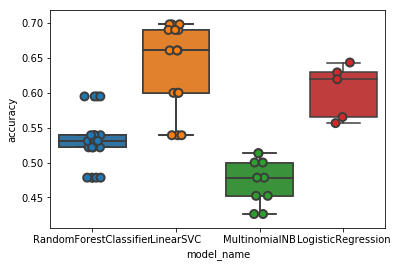

In [242]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=42),
    
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    import seaborn as sns
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [243]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.637708
LogisticRegression        0.602799
MultinomialNB             0.473959
RandomForestClassifier    0.532986
Name: accuracy, dtype: float64

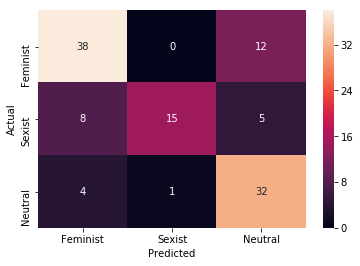

In [244]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, lyrics_dataframe.index, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
#fig, ax = plt.subplot()#figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [241]:
model.fit(features, labels)
N = 10
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Feminist':
  . Top unigrams:
       . girls
       . boys
       . woman
       . uh
       . mess
       . live
       . say
       . speak
       . cause
       . like
  . Top bigrams:
       . don need
       . yes yes
       . oh girls
       . want want
       . don wanna
       . don let
       . mind ve
       . uh uh
       . cause just
       . way don
# 'Neutral':
  . Top unigrams:
       . child
       . remember
       . blue
       . river
       . happy
       . water
       . lord
       . singing
       . somebody
       . running
  . Top bigrams:
       . yes want
       . dah dah
       . jammin jammin
       . feel good
       . want yeah
       . peace mind
       . round round
       . need need
       . don belong
       . somebody loved
# 'Sexist':
  . Top unigrams:
       . baby
       . body
       . slow
       . night
       . butt
       . girl
       . wanna
       . sex
       . didn
       . satisfaction
  . Top bigrams:
       . make love
       . lit

In [245]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=lyrics_dataframe['Category'].unique()))

              precision    recall  f1-score   support

    Feminist       0.76      0.76      0.76        50
      Sexist       0.94      0.54      0.68        28
     Neutral       0.65      0.86      0.74        37

   micro avg       0.74      0.74      0.74       115
   macro avg       0.78      0.72      0.73       115
weighted avg       0.77      0.74      0.74       115



In [ ]:
##### stop here #######

In [158]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(lyrics_dataframe['Lyrics'],label_lyrics , test_size=0.1, random_state=43)

In [159]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(lyrics_dataframe['Lyrics']).toarray()
labels = lyrics_dataframe.labels
features.shape

(574, 1843)

In [160]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, indices_train,indices_test = train_test_split(features, labels, lyrics_dataframe.index, test_size=0.33, random_state=0)

model = svm.LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [161]:
sklearn.metrics.confusion_matrix(y_test,y_pred)

array([[29,  9, 16],
       [ 5, 42, 24],
       [ 3, 16, 46]])

In [162]:
res = 0
for i,j in zip(y_pred, y_test):
    if(i==j):
        res += 1
accuracy = 100*res/len(y_pred)
accuracy

61.578947368421055

# Degrading terms : statistics and insights into the bag of words

In [111]:
lo_wcp = []
for each_song in bow:
    eachsong_lyrics = each_song[2:]
    wcp = {}
    for wordcount_pair in eachsong_lyrics:
        i = wordcount_pair.split(':')
        wcp[i[0]] = i[1]
    lo_wcp.append(wcp)
    
lo_wcp

[{'i': '6',
  'the': '4',
  'you': '2',
  'to': '2',
  'and': 'and',
  'a': '3',
  'me': '1',
  'it': '1',
  'my': '1',
  'is': '2',
  'of': '3',
  'your': '1',
  'that': '1',
  'are': '2',
  'we': '2',
  'am': '2',
  'will': '2',
  'for': '4',
  'be': '1',
  'have': '2',
  'so': '1',
  'this': '1',
  'like': '2',
  'de': '1',
  'up': '1',
  'was': '2',
  'if': '1',
  'got': '1',
  'would': '1',
  'been': '1',
  'these': '2',
  'seem': '1',
  'someon': '1',
  'understand': '1',
  'pass': '1',
  'river': '1',
  'met': '1',
  'piec': '1',
  'damn': '1',
  'worth': '1',
  'flesh': '1',
  'grace': '1',
  'poor': '2',
  'somehow': '1',
  'ignor': '1',
  'passion': '1',
  'tide': '1',
  'season': '1',
  'seed': '1',
  'resist': '1',
  'order': '2',
  'piti': '1',
  'fashion': '1',
  'grant': '1',
  'captur': '2',
  'ici': '1',
  'soil': '1',
  'patienc': '1',
  'social': '2',
  'highest': '2',
  'slice': '1',
  'leaf': '1',
  'lifeless': '1',
  'arrang': '1',
  'wilder': '1',
  'shark': '1',

In [112]:
lo_track_id = []
for each_song in bow:
    lo_track_id.append(each_song[0])


In [113]:
len(lo_track_id)

210519

In [114]:
len(lo_wcp)

210519

In [115]:
msd = pd.DataFrame({'TrackID': lo_track_id,'BOW': lo_wcp})
for word in feature_list[2:]:
    msd[word] = len(msd) * [0]


In [116]:
# word_count_dataset_list =[]

# for word in feature_list[2:]:
#     word_count_list = []
#     for  song in tokenized_lyrics: # These are the bow lyrics
#         c = song.count(word)
#         word_count_list.append(c)
#     word_count_dataset_list.append(word_count_list)

# i=0
# word_count_lyrics_X = pd.DataFrame()
# for col in feature_list[2:]:
#     word_count_lyrics_X[col] = (word_count_dataset_list[i])
#     i = i + 1



fill_dataframe = []
for col in feature_list[2:]:
    print(col)
    word_count = []
    for wcp in lo_wcp:
        if col in wcp:
            word_count.append(wcp[col])
        else:
            word_count.append(0)
    fill_dataframe.append(word_count)
            


   

woman
women
pretti
beauti
mama
ladi
better
live
life
worth
friend
strong
stronger
power
believ
learn
fire
star
best
fight
free
respect
human
queen
grow
dream
truth
liberti
boss
shine
sister
flawless
perfect
confid
independ
superwoman
bitch
bubbl
fuck
nigga
butt
feel
littl
hot
ass
bodi
shit
hoe
man
sex
shake
bad
hard
dick
touch
fuckin
pussi
lick
sexi
damn
money


In [117]:
fill_dataframe

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  '2',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  '1',
  0,
  0,
  0,
  '1',
  0,
  0,
  0,
  '1',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  '2',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [118]:
i=0
for col in feature_list[2:]:
    msd[col] = (fill_dataframe[i])
    i = i + 1

In [119]:
msd

TrackID                                                BOW  \
0       TRAAAAV128F421A322  {'i': '6', 'the': '4', 'you': '2', 'to': '2', ...   
1       TRAAABD128F429CF47  {'i': 'i0', 'you': '17', 'to': '8', 'and': '2'...   
2       TRAAAED128E0783FAB  {'i': '28', 'the': '15', 'you': '2', 'to': '12...   
3       TRAAAEF128F4273421  {'i': '5', 'the': '4', 'you': 'you', 'to': '2'...   
4       TRAAAEW128F42930C0  {'i': '4', 'to': '5', 'and': '7', 'a': '2', 'm...   
5       TRAAAFD128F92F423A  {'i': 'i6', 'the': '4', 'to': '1', 'and': '3',...   
6       TRAAAGF12903CEC202  {'en': '1', 'e': '1', 'end': '1', 'du': '2', '...   
7       TRAAAHJ128F931194C  {'i': '4', 'the': '11', 'you': '2', 'to': '7',...   
8       TRAAAHZ128E0799171  {'i': '39', 'the': '30', 'you': '10', 'to': '1...   
9       TRAAAJG128F9308A25  {'i': '6', 'the': '9', 'and': '3', 'a': '4', '...   
10      TRAAAOF128F429C156  {'i': 'i4', 'the': 'the0', 'you': '2', 'to': '...   
11      TRAAARJ128F9320760  {'i': '6', 'the': '7', 'you': 'you', 'to': '1'...   
12      TRAAAUC128F428716F  {'i': 'ii', 'the': '3', 'you': '6', 'to': '3',...   
13      TRAAAZF12903CCCF6B  {'i': '25', 'the': '7', 'you': '14', 'to': '17...   
14      TRAABEV12903CC53A4  {'the': '1', 'to': '1', 'a': '1', 'in': '1', '...   
15      TRAABHB12903CAFC2F  {'i': '2', 'the': '7', 'to': 'to', 'and': '1',...   
16      TRAABHC128F933A3F8  {'i': '3', 'the': '16', 'you': '8', 'to': 'to'...   
17      TRAABIG128F9356C56  {'i': '28', 'the': '77', 'you': 'you1', 'to': ...   
18      TRAABJS128F9325C99  {'i': '5', 'the': '3', 'you': 'you', 'to': '3'...   
19      TRAABJV128F1460C49  {'i': '6', 'the': '5', 'you': '10', 'to': 'to'...   
20      TRAABLR128F423B7E3  {'i': 'ii', 'the': '5', 'you': '6', 'to': '3',...   
21      TRAABOA128F933684A  {'i': 'i5', 'the': 'the4', 'you': '1', 'to': '...   
22      TRAABOG128F42955B1  {'i': '20', 'the': '6', 'you': '2', 'to': '3',...   
23      TRAABPG128F14774DD  {'i': '2', 'the': '6', 'you': '2', 'to': 'to',...   
24      TRAABVM128F92CA9DC  {'i': 'i9', 'the': '5', 'you': '2', 'to': 'to'...   
25      TRAABXH128F42955D6  {'i': '3', 'the': '1', 'you': '2', 'and': '4',...   
26      TRAACER128F4290F96  {'i': '4', 'the': '11', 'you': '19', 'to': 'to...   
27      TRAACFV128F935E50B  {'i': '22', 'the': '11', 'you': '2', 'to': '15...   
28      TRAACHN128F1489601  {'i': '8', 'the': '13', 'you': '1', 'and': '3'...   
29      TRAACIE128F428495B  {'i': '2', 'the': 'the', 'you': '16', 'to': '3...   
...                    ...                                                ...   
210489  TRZZYFQ128F1487E4E  {'i': '7', 'the': '13', 'you': '11', 'to': '1'...   
210490  TRZZYGA128EF3443B1  {'me': '4', 'que': '2', 'de': '5', 'la': '1', ...   
210491  TRZZYIT128F42573A3  {'i': 'i3', 'the': 'the', 'you': '21', 'to': '...   
210492  TRZZYJR128F4272825  {'i': '4', 'the': '5', 'you': 'you', 'to': '2'...   
210493  TRZZYLO12903CAC06C  {'i': 'i3', 'the': '11', 'you': '11', 'to': '3...   
210494  TRZZYMU128E0792400  {'i': '2i', 'you': '16', 'to': '12', 'and': '8...   
210495  TRZZYNK128F934EC4D  {'no': '1', 'que': '2', 'de': '1', 'y': '8', '...   
210496  TRZZYOB128F146F524  {'de': '5', 'la': '2', 'en': '1', 'un': '9', '...   
210497  TRZZYPE128F4268053  {'i': 'i', 'the': '1', 'in': '2', 'my': '3', '...   
210498  TRZZYTX128F92EBE33  {'i': '22', 'the': '9', 'you': '6', 'to': '23'...   
210499  TRZZYUG12903CAC764  {'i': 'i6', 'the': '14', 'you': '2', 'to': '12...   
210500  TRZZYZG128F425A229  {'i': '8', 'the': '7', 'to': 'to', 'and': '3',...   
210501  TRZZZCB128F4249252  {'i': 'i6', 'the': '9', 'you': '14', 'to': '1'...   
210502  TRZZZCL128F428BB80  {'i': '5', 'the': '18', 'you': '4', 'to': '1',...   
210503  TRZZZEY128F93311FC  {'i': '4', 'the': '4', 'to': '8', 'and': '3', ...   
210504  TRZZZGZ128F4292B90  {'i': '44', 'the': '3', 'you': '8', 'to': '2',...   
210505  TRZZZHL128F9329CFB  {'i': 'i0', 'the': '1the', 'you': '27', 'to': ...   
210506  TRZZZKL128F9349F1D  {'i': '7', 'the': '1',

In [120]:
msd_ready = msd.drop(['TrackID', 'BOW'], axis=1)

In [121]:
msd_ready

woman women pretti beauti mama ladi better live life worth  ...  bad  \
0          0     0      0      0    0    0      0    0    0     1  ...    0   
1          0     0      0      0    0    0      0    1    0     0  ...    0   
2          0     0      1      0    0    0      0    0    0     0  ...    0   
3          0     0      0      0    0    0      0    0    0     0  ...    0   
4          0     0      0      0    0    0      0    0    0     0  ...    0   
5          0     0      0      0    0    0      1    0    0     0  ...    0   
6          0     0      0      0    0    0      0    0    0     0  ...    0   
7          0     0      0      0    0    0      0    0    0     0  ...    0   
8          0     0      0      0    0    0      0    1    0     0  ...    0   
9          0     0      0      0    0    0      0    0    0     0  ...    1   
10         0     0      0      0    0    0      1    0    0     0  ...    0   
11         0     0      0      0    0    0      0    0    0     0  ...    0   
12         0     0      0      0    0    0      0    1    0     0  ...    0   
13         0     0      0      0    0    0      0    0    0     0  ...    0   
14         0     0      0      0    0    0      0    0    0     0  ...    0   
15         0     0      0      0    0    0      0    0    0     0  ...    0   
16         0     0      0      0    0    0      0    0    0     0  ...    0   
17         0     0      0      0    0    0      0    3    6     0  ...    0   
18         0     0      0      0    0    0      0    0    0     0  ...    0   
19         0     0      0      0    0    0      0    0    0     0  ...    0   
20         0     0      0      0    0    0      0    1    1     0  ...    0   
21         0     0      0      0    0    0      1    0    1     0  ...    0   
22         0     0      0      0    0    0      0    0    8     0  ...    0   
23         0     0      0      0    0    0      1    0    0     0  ...    0   
24         0     0      0      0    0    0      0    5    2     0  ...    0   
25         0     0      0      0    0    0      0    0    0     0  ...    0   
26         0     0      1      0    0    0      0    0    0     0  ...    0   
27         0     0      0      0    1    0      0    0    0     0  ...    0   
28         0     0      0      0    0    0      0    0   11     0  ...    0   
29         0     0      0      0    0    0      3    0    0     0  ...    0   
...      ...   ...    ...    ...  ...  ...    ...  ...  ...   ...  ...   ..   
210489     0     0      0      0    0    0      0    0    0     0  ...    0   
210490     0     0      0      0    0    0      0    0    0     0  ...    0   
210491     0     0      0      0    0    0      0    0    0     2  ...    6   
210492     0     1      0      0    0    0      0    0    1     0  ...    0   
210493     0     0      0      0    0    0      0    0    0     0  ...    0   
210494     0     0      0      0    0    0      2    6    0     0  ...    0   
210495     0     0      0      0    0    0      0    0    0     0  ...    0   
210496     0     0      0      0    0    0      0    0    0     0  ...    0   
210497     0     0      0      0    0    0      0    0    0     0  ...    0   
210498     0     0      0      0    0    0      0    0    0     0  ...    0   
210499     0     0      1      0    0    0      1    1    5     0  ...    1   
210500     0     0      0      0    0    0      0    0    0     0  ...    0   
210501     4     0      0      0    0    0      0    0    0     0  ...    0   
210502     0     0      0      0    0    0      0    0    0     0  ...    0   
210503     0     0      0      0    0    0      0    0    0     0  ...    0   
210504     0     0      0      0    0    0      0    0    0     1  ...    0   
210505     0     0      0      0    0    0      0    3    0     0  ...    0   
210506     0     0      0      0    0    0      0    0    0     0  ...    0   
210507     0     0      0      0    0    0      0    4   

In [122]:
msd_ready_pred = clf.predict(msd_ready)

In [123]:
msd_ready_pred

array([ 1,  0,  1, ..., -1,  1, -1])

In [124]:
msd['Prediction']=list(msd_ready_pred)
msd

TrackID                                                BOW  \
0       TRAAAAV128F421A322  {'i': '6', 'the': '4', 'you': '2', 'to': '2', ...   
1       TRAAABD128F429CF47  {'i': 'i0', 'you': '17', 'to': '8', 'and': '2'...   
2       TRAAAED128E0783FAB  {'i': '28', 'the': '15', 'you': '2', 'to': '12...   
3       TRAAAEF128F4273421  {'i': '5', 'the': '4', 'you': 'you', 'to': '2'...   
4       TRAAAEW128F42930C0  {'i': '4', 'to': '5', 'and': '7', 'a': '2', 'm...   
5       TRAAAFD128F92F423A  {'i': 'i6', 'the': '4', 'to': '1', 'and': '3',...   
6       TRAAAGF12903CEC202  {'en': '1', 'e': '1', 'end': '1', 'du': '2', '...   
7       TRAAAHJ128F931194C  {'i': '4', 'the': '11', 'you': '2', 'to': '7',...   
8       TRAAAHZ128E0799171  {'i': '39', 'the': '30', 'you': '10', 'to': '1...   
9       TRAAAJG128F9308A25  {'i': '6', 'the': '9', 'and': '3', 'a': '4', '...   
10      TRAAAOF128F429C156  {'i': 'i4', 'the': 'the0', 'you': '2', 'to': '...   
11      TRAAARJ128F9320760  {'i': '6', 'the': '7', 'you': 'you', 'to': '1'...   
12      TRAAAUC128F428716F  {'i': 'ii', 'the': '3', 'you': '6', 'to': '3',...   
13      TRAAAZF12903CCCF6B  {'i': '25', 'the': '7', 'you': '14', 'to': '17...   
14      TRAABEV12903CC53A4  {'the': '1', 'to': '1', 'a': '1', 'in': '1', '...   
15      TRAABHB12903CAFC2F  {'i': '2', 'the': '7', 'to': 'to', 'and': '1',...   
16      TRAABHC128F933A3F8  {'i': '3', 'the': '16', 'you': '8', 'to': 'to'...   
17      TRAABIG128F9356C56  {'i': '28', 'the': '77', 'you': 'you1', 'to': ...   
18      TRAABJS128F9325C99  {'i': '5', 'the': '3', 'you': 'you', 'to': '3'...   
19      TRAABJV128F1460C49  {'i': '6', 'the': '5', 'you': '10', 'to': 'to'...   
20      TRAABLR128F423B7E3  {'i': 'ii', 'the': '5', 'you': '6', 'to': '3',...   
21      TRAABOA128F933684A  {'i': 'i5', 'the': 'the4', 'you': '1', 'to': '...   
22      TRAABOG128F42955B1  {'i': '20', 'the': '6', 'you': '2', 'to': '3',...   
23      TRAABPG128F14774DD  {'i': '2', 'the': '6', 'you': '2', 'to': 'to',...   
24      TRAABVM128F92CA9DC  {'i': 'i9', 'the': '5', 'you': '2', 'to': 'to'...   
25      TRAABXH128F42955D6  {'i': '3', 'the': '1', 'you': '2', 'and': '4',...   
26      TRAACER128F4290F96  {'i': '4', 'the': '11', 'you': '19', 'to': 'to...   
27      TRAACFV128F935E50B  {'i': '22', 'the': '11', 'you': '2', 'to': '15...   
28      TRAACHN128F1489601  {'i': '8', 'the': '13', 'you': '1', 'and': '3'...   
29      TRAACIE128F428495B  {'i': '2', 'the': 'the', 'you': '16', 'to': '3...   
...                    ...                                                ...   
210489  TRZZYFQ128F1487E4E  {'i': '7', 'the': '13', 'you': '11', 'to': '1'...   
210490  TRZZYGA128EF3443B1  {'me': '4', 'que': '2', 'de': '5', 'la': '1', ...   
210491  TRZZYIT128F42573A3  {'i': 'i3', 'the': 'the', 'you': '21', 'to': '...   
210492  TRZZYJR128F4272825  {'i': '4', 'the': '5', 'you': 'you', 'to': '2'...   
210493  TRZZYLO12903CAC06C  {'i': 'i3', 'the': '11', 'you': '11', 'to': '3...   
210494  TRZZYMU128E0792400  {'i': '2i', 'you': '16', 'to': '12', 'and': '8...   
210495  TRZZYNK128F934EC4D  {'no': '1', 'que': '2', 'de': '1', 'y': '8', '...   
210496  TRZZYOB128F146F524  {'de': '5', 'la': '2', 'en': '1', 'un': '9', '...   
210497  TRZZYPE128F4268053  {'i': 'i', 'the': '1', 'in': '2', 'my': '3', '...   
210498  TRZZYTX128F92EBE33  {'i': '22', 'the': '9', 'you': '6', 'to': '23'...   
210499  TRZZYUG12903CAC764  {'i': 'i6', 'the': '14', 'you': '2', 'to': '12...   
210500  TRZZYZG128F425A229  {'i': '8', 'the': '7', 'to': 'to', 'and': '3',...   
210501  TRZZZCB128F4249252  {'i': 'i6', 'the': '9', 'you': '14', 'to': '1'...   
210502  TRZZZCL128F428BB80  {'i': '5', 'the': '18', 'you': '4', 'to': '1',...   
210503  TRZZZEY128F93311FC  {'i': '4', 'the': '4', 'to': '8', 'and': '3', ...   
210504  TRZZZGZ128F4292B90  {'i': '44', 'the': '3', 'you': '8', 'to': '2',...   
210505  TRZZZHL128F9329CFB  {'i': 'i0', 'the': '1the', 'you': '27', 'to': ...   
210506  TRZZZKL128F9349F1D  {'i': '7', 'the': '1',

In [126]:
col_list = ["TrackID", "Prediction"]
msd = msd[col_list]

In [132]:
final_dataframe = msd.merge(year_artist_name_title_genre, left_on="TrackID", right_on="track_id")

In [128]:
len(year_artist_name_title_genre)

152793

In [129]:
len(msd_ready)

210519

In [133]:
final_dataframe.shape

(64107, 7)

In [134]:
final_dataframe

TrackID  Prediction  year                artist_name  \
0      TRAAAEF128F4273421           1  1982                   adam ant   
1      TRAAAGF12903CEC202           0  2005          halvdan sivertsen   
2      TRAAARJ128F9320760           1  1984           planet p project   
3      TRAABJS128F9325C99           1  2006                beach house   
4      TRAABLR128F423B7E3           1  1987                 blue rodeo   
5      TRAABVM128F92CA9DC           0  2004                      tesla   
6      TRAACER128F4290F96           1  2004  the dillinger escape plan   
7      TRAACIE128F428495B           1  1994                  pearl jam   
8      TRAACZN128F93236B1          -1  2004              saul williams   
9      TRAADLH12903CA70EE           0  2003       the suicide machines   
10     TRAADNA128F9331246           1  1992         stevie ray vaughan   
11     TRAADQL128F427D281           1  2008                    man man   
12     TRAADSV128F42BC36A           0  1983                  aldo nova   
13     TRAADYB128F92D7E73           1  2009               eliane elias   
14     TRAAEDY12903CBBFA7           0  2005             klovner i kamp   
15     TRAAEHW128F9344FD3           1  2007            leftã¶ver crack   
16     TRAAENC128F1451DE9           1  1995            francis dunnery   
17     TRAAENM128EF33EDAA           0  2006                       klee   
18     TRAAEPG128F429139A           1  2001       alabama thunderpussy   
19     TRAAFEU128E078581C           0  1995                     r.e.m.   
20     TRAAFGQ128F427D884          -1  2008                  the kooks   
21     TRAAFOH128E078BD7E           0  2004                  imperanon   
22     TRAAGAM128F428DCBE           0  1985           la polla records   
23     TRAAGEC128E079252C           1  2000            nine inch nails   
24     TRAAGIJ128F933430E           1  1981                  chron gen   
25     TRAAGJV128F1464090           1  1963                lesley gore   
26     TRAAGNS128E07824BD          -1  1978                  kate bush   
27     TRAAGOZ128F92EB3D4           1  2008            david archuleta   
28     TRAAGPF12903CE027E           1  1990               slim whitman   
29     TRAAGPJ128F428CD1B           1  2005    queens of the stone age   
...                   ...         ...   ...                        ...   
64077  TRZZOUR12903CDCF7C           0  1992                   godflesh   
64078  TRZZPLZ128F426E202           1  2005             spiers & boden   
64079  TRZZPUT128F92EF49D          -1  2004                   lady saw   
64080  TRZZQIP128F92EFEAD           1  1977                       abba   
64081  TRZZQLC12903CE2FEC          -1  2005               craig morgan   
64082  TRZZQNK128F92F99B7           1  2004                 dealership   
64083  TRZZQYZ12903CB1186          -1  1962              woody guthrie   
64084  TRZZRIP128F92FAD5E           1  2005                    rev run   
64085  TRZZRKS12903CE4387           0  2004             onelinedrawing   
64086  TRZZSRE128F92DCFBF           0  1997                     anggun   
64087  TRZZTIY128F145B9A7           1  1980       stiff little fingers   
64088  TRZZTUK128F14A2EA9          -1  1983                 wang chung   
64089  TRZZUPR12903CC11FE           1  2006                 divinefire   
64090  TRZZUYD128E0794EE6           1  2004              hayseed dixie   
64091  TRZZVAL128F92EBE15           0  2005                   lofofora   
64092  TRZZVIB128F42621C3           1  1999                 u.s. bombs   
64093  TRZZVJC128E078907B           1  1991      the smashing pumpkins   
64094  TRZZWTV128F930ECD0           0  1994                steve perry   
64095  TRZZWXV128F428F20D           1  2002                keith urban   
64096  TRZZWZE128F92D2FCA           1  2000              atomic kitten   
64097  TRZZWZL128F4246C5A           0  1987                    tankard   
64098  TRZZXHU12903CF4706          -1  2007               we the kings   
64099  TRZZXJT128F931D